### Importações necessárias:

In [3]:
import os
import random
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras import Sequential
from keras.layers import Flatten, Conv2D, MaxPooling2D, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model

from sklearn.metrics import confusion_matrix, recall_score

In [4]:
# Diretórios
train_dir = 'dataset/dog_cat_dataset/training_set/training_set'
test_dir = 'dataset/dog_cat_dataset/test_set/test_set'

images = []
labels = []

### Verificação do funcionamento:

In [5]:
print(os.listdir(train_dir))
print(os.listdir(test_dir))

['cats', 'dogs']
['cats', 'dogs']


In [6]:
SIZE = 300

# Mapeia os labels para inteiros
unique_labels = sorted(os.listdir(train_dir))
label_to_int = {label: idx for idx, label in enumerate(unique_labels)}

for folder_name in os.listdir(train_dir):
    folder_path = os.path.join(train_dir, folder_name)

    if os.path.isdir(folder_path):
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            image = cv2.imread(file_path)

            if image is not None and image.size != 0: # Verifica se a imagem foi lida corretamente
                resized_image = cv2.resize(image, (SIZE, SIZE))
                images.append(resized_image)
                # Converte o label string para um inteiro usando o mapeamento
                labels.append(label_to_int[folder_name])

print("Exemplo de labels convertidos:", labels[:10])

Exemplo de labels convertidos: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


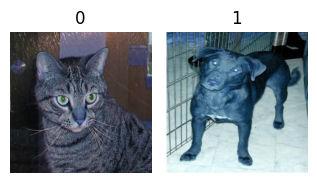

In [7]:
# Plot de imagens de exemplo
unique_labels = list(set(labels))
num_labels = len(unique_labels)
num_labels_per_line = 4
labels_array = np.array(labels)

for i, label in enumerate(unique_labels):
    index = labels_array.tolist().index(label)
    image = images[index]
    plt.subplot(num_labels // num_labels_per_line + 1, num_labels_per_line, i+1)
    plt.imshow(image)
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

### Divisão do dataset entre train e test:

In [8]:
train = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(SIZE, SIZE),
    shuffle=True,
    )

test  = tf.keras.preprocessing.image_dataset_from_directory(
    directory = test_dir,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(SIZE, SIZE),
    shuffle=False,
    )

Found 8005 files belonging to 2 classes.
Found 2023 files belonging to 2 classes.


### Processo de normalização das imagens:

In [9]:
def processamento(image,label):
    image = tf.cast(image/255 , tf.float32)
    return image , label

train = train.map(processamento)
test  = test.map(processamento)

### Modelo MobileNetV2 foi utilizado:

In [10]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Saída única para classificação binária
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 10, 10, 1280)     2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,422,081
Trainable params: 164,097
Non-tr

In [12]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Adição de Checkpoints e EarlyStopping:

In [13]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(
        patience=5,
        restore_best_weights=True
    ),

    ReduceLROnPlateau(
        factor=0.1,
        patience=3,
        min_lr=1e-6
    ),

    ModelCheckpoint(
    filepath = 'model.keras',
    monitor ='val_accuracy',
    verbose = True,
    save_best_only = True,
    save_weights_only=False,
    mode = 'max'
    )
]

### Fitting do modelo:

In [14]:
history = model.fit(train, batch_size = 32, epochs=20, validation_data=test, callbacks=callbacks)

Epoch 1/20
251/251 [==============================] - ETA: 0s - loss: 0.0683 - accuracy: 0.9739
Epoch 1: val_accuracy improved from -inf to 0.98913, saving model to model.keras
251/251 [==============================] - 29s 86ms/step - loss: 0.0683 - accuracy: 0.9739 - val_loss: 0.0386 - val_accuracy: 0.9891 - lr: 0.0010
Epoch 2/20
250/251 [============================>.] - ETA: 0s - loss: 0.0396 - accuracy: 0.9865
Epoch 2: val_accuracy improved from 0.98913 to 0.99110, saving model to model.keras
251/251 [==============================] - 20s 79ms/step - loss: 0.0396 - accuracy: 0.9865 - val_loss: 0.0350 - val_accuracy: 0.9911 - lr: 0.0010
Epoch 3/20
250/251 [============================>.] - ETA: 0s - loss: 0.0233 - accuracy: 0.9912
Epoch 3: val_accuracy did not improve from 0.99110
251/251 [==============================] - 20s 78ms/step - loss: 0.0233 - accuracy: 0.9913 - val_loss: 0.0343 - val_accuracy: 0.9896 - lr: 0.0010
Epoch 4/20
250/251 [============================>.] - ETA:

In [15]:
# Salvar o modelo
model.save('dog_or_cat.keras')
print("Modelo salvo com sucesso!")

Modelo salvo com sucesso!


### Resultado:

In [16]:
model = load_model('dog_or_cat.keras')

best_model_accuracy = model.evaluate(train)[1]
best_model_val_accuracy = model.evaluate(test)[1]

# best_model_accuracy = max(history.history['accuracy'])
# best_model_val_accuracy = max(history.history['val_accuracy'])

print(f'Training Accuracy: {(best_model_accuracy * 100):.2f}%')
print(f'Validation Accuracy: {(best_model_val_accuracy * 100):.2f}%')

64/64 [==============================] - 4s 59ms/step - loss: 0.0343 - accuracy: 0.9896
Training Accuracy: 99.58%
Validation Accuracy: 98.96%


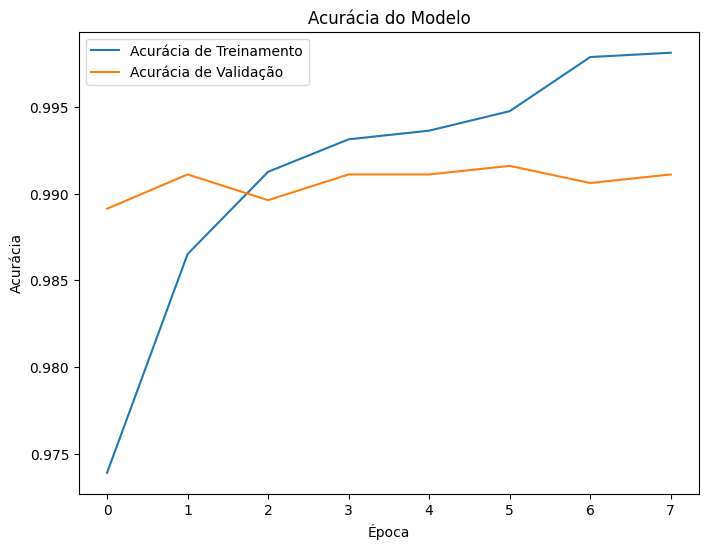

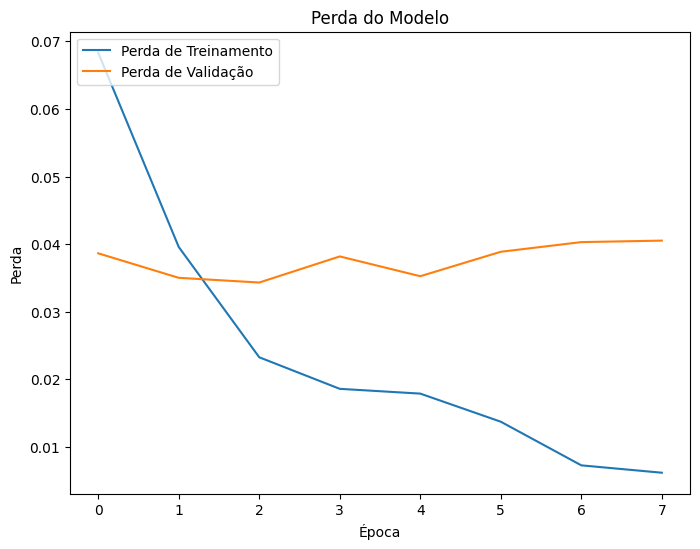

In [17]:
# Plot de Acurácia
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Acurácia de Treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Acurácia do Modelo')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend(loc='upper left')
plt.show()

# Plot de Perda
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Perda de Treinamento')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.title('Perda do Modelo')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend(loc='upper left')
plt.show()

64/64 [==============================] - 4s 58ms/step
Matriz de Confusão:
[[ 998   13]
 [   8 1004]]


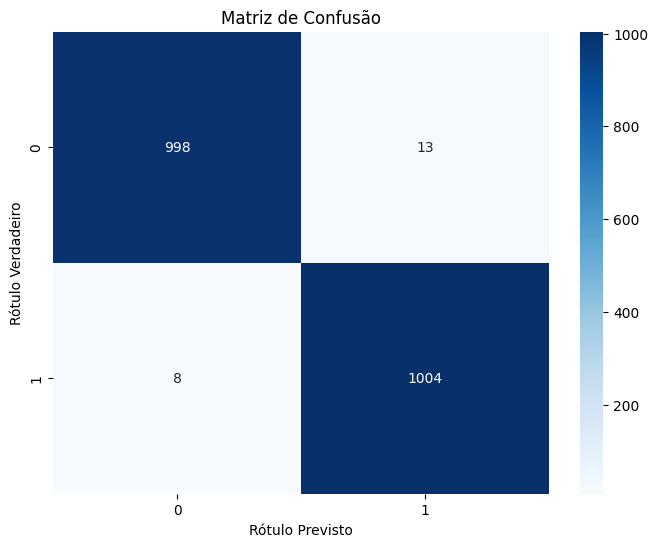

Recall: 0.9920948616600791


In [18]:
y_pred = model.predict(test)
y_pred_labels = (y_pred > 0.5).astype(int).flatten()
y_true = np.concatenate([y for x, y in test], axis=0).flatten()

cm = confusion_matrix(y_true, y_pred_labels)
print("Matriz de Confusão:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Rótulo Previsto')
plt.ylabel('Rótulo Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

recall = recall_score(y_true, y_pred_labels, average='binary')
print("Recall:", recall)

### Funções para teste

In [19]:
def load_and_preprocess_image(image_path):
    image = cv2.imread(image_path)

    if image is None:
        raise ValueError("Não foi possível carregar a imagem. Verifique o caminho:", image_path)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (SIZE, SIZE))
    image = image.astype('float32') / 255.0

    return image

##### lista com os nomes das raças

In [20]:
classes_filtradas = [
    "n02085620-Chihuahua",
    "n02085936-Maltese_dog",
    "n02086079-Pekinese",
    "n02086240-Shih-Tzu",
    "n02086910-papillon",
    "n02088094-Afghan_hound",
    "n02088364-beagle",
    "n02088466-bloodhound",
    "n02094433-Yorkshire_terrier",
    "n02097047-miniature_schnauzer",
    "n02099601-golden_retriever",
    "n02099712-Labrador_retriever",
    "n02106662-German_shepherd",
    "n02108915-French_bulldog",
    "n02110185-Siberian_husky",
    "n02113799-standard_poodle",
    "n02108089-boxer",
    "n02102318-cocker_spaniel",
    "n02109525-Saint_Bernard",
    "n02110958-pug",
    "n02106550-Rottweiler",
    "n02105162-malinois",
    "n02106166-Border_collie",
    "n02107312-miniature_pinscher"
]


In [21]:
# Lista com os nomes das raças na ordem utilizada no treinamento
classes = [
    "n02085620-Chihuahua",
    "n02085782-Japanese_spaniel",
    "n02085936-Maltese_dog",
    "n02086079-Pekinese",
    "n02086240-Shih-Tzu",
    "n02086646-Blenheim_spaniel",
    "n02086910-papillon",
    "n02087046-toy_terrier",
    "n02087394-Rhodesian_ridgeback",
    "n02088094-Afghan_hound",
    "n02088238-basset",
    "n02088364-beagle",
    "n02088466-bloodhound",
    "n02088632-bluetick",
    "n02089078-black-and-tan_coonhound",
    "n02089867-Walker_hound",
    "n02089973-English_foxhound",
    "n02090379-redbone",
    "n02090622-borzoi",
    "n02090721-Irish_wolfhound",
    "n02091032-Italian_greyhound",
    "n02091134-whippet",
    "n02091244-Ibizan_hound",
    "n02091467-Norwegian_elkhound",
    "n02091635-otterhound",
    "n02091831-Saluki",
    "n02092002-Scottish_deerhound",
    "n02092339-Weimaraner",
    "n02093256-Staffordshire_bullterrier",
    "n02093428-American_Staffordshire_terrier",
    "n02093647-Bedlington_terrier",
    "n02093754-Border_terrier",
    "n02093859-Kerry_blue_terrier",
    "n02093991-Irish_terrier",
    "n02094114-Norfolk_terrier",
    "n02094258-Norwich_terrier",
    "n02094433-Yorkshire_terrier",
    "n02095314-wire-haired_fox_terrier",
    "n02095570-Lakeland_terrier",
    "n02095889-Sealyham_terrier",
    "n02096051-Airedale",
    "n02096177-cairn",
    "n02096294-Australian_terrier",
    "n02096437-Dandie_Dinmont",
    "n02096585-Boston_bull",
    "n02097047-miniature_schnauzer",
    "n02097130-giant_schnauzer",
    "n02097209-standard_schnauzer",
    "n02097298-Scotch_terrier",
    "n02097474-Tibetan_terrier",
    "n02097658-silky_terrier",
    "n02098105-soft-coated_wheaten_terrier",
    "n02098286-West_Highland_white_terrier",
    "n02098413-Lhasa",
    "n02099267-flat-coated_retriever",
    "n02099429-curly-coated_retriever",
    "n02099601-golden_retriever",
    "n02099712-Labrador_retriever",
    "n02099849-Chesapeake_Bay_retriever",
    "n02100236-German_short-haired_pointer",
    "n02100583-vizsla",
    "n02100735-English_setter",
    "n02100877-Irish_setter",
    "n02101006-Gordon_setter",
    "n02101388-Brittany_spaniel",
    "n02101556-clumber",
    "n02102040-English_springer",
    "n02102177-Welsh_springer_spaniel",
    "n02102318-cocker_spaniel",
    "n02102480-Sussex_spaniel",
    "n02102973-Irish_water_spaniel",
    "n02104029-kuvasz",
    "n02104365-schipperke",
    "n02105056-groenendael",
    "n02105162-malinois",
    "n02105251-briard",
    "n02105412-kelpie",
    "n02105505-komondor",
    "n02105641-Old_English_sheepdog",
    "n02105855-Shetland_sheepdog",
    "n02106030-collie",
    "n02106166-Border_collie",
    "n02106382-Bouvier_des_Flandres",
    "n02106550-Rottweiler",
    "n02106662-German_shepherd",
    "n02107142-Doberman",
    "n02107312-miniature_pinscher",
    "n02107574-Greater_Swiss_Mountain_dog",
    "n02107683-Bernese_mountain_dog",
    "n02107908-Appenzeller",
    "n02108000-EntleBucher",
    "n02108089-boxer",
    "n02108422-bull_mastiff",
    "n02108551-Tibetan_mastiff",
    "n02108915-French_bulldog",
    "n02109047-Great_Dane",
    "n02109525-Saint_Bernard",
    "n02109961-Eskimo_dog",
    "n02110063-malamute",
    "n02110185-Siberian_husky",
    "n02110627-affenpinscher",
    "n02110806-basenji",
    "n02110958-pug",
    "n02111129-Leonberg",
    "n02111277-Newfoundland",
    "n02111500-Great_Pyrenees",
    "n02111889-Samoyed",
    "n02112018-Pomeranian",
    "n02112137-chow",
    "n02112350-keeshond",
    "n02112706-Brabancon_griffon",
    "n02113023-Pembroke",
    "n02113186-Cardigan",
    "n02113624-toy_poodle",
    "n02113712-miniature_poodle",
    "n02113799-standard_poodle",
    "n02113978-Mexican_hairless",
    "n02115641-dingo",
    "n02115913-dhole",
    "n02116738-African_hunting_dog"
]


### Teste Real:

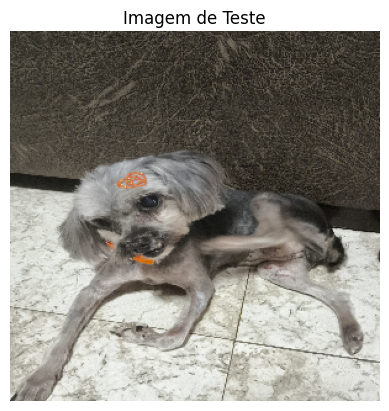

1/1 [==============================] - 0s 24ms/step
Índice (0 = gato, 1 = cachorro): 1.0000
Rótulo previsto: Cachorro


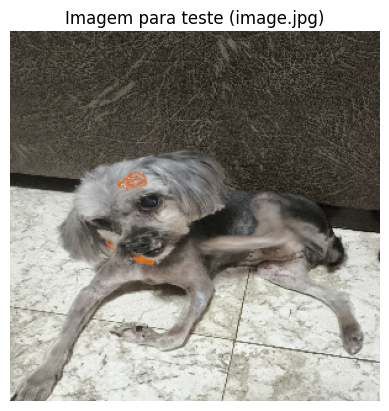

1/1 [==============================] - 2s 2s/step
Predição (vetor de probabilidades):
Top 5 índices: [ 8 17  1  3  4]
Raça: n02094433-Yorkshire_terrier - Probabilidade: 56.68%
Raça: n02102318-cocker_spaniel - Probabilidade: 14.25%
Raça: n02085936-Maltese_dog - Probabilidade: 5.32%
Raça: n02086240-Shih-Tzu - Probabilidade: 4.50%
Raça: n02086910-papillon - Probabilidade: 4.21%


In [24]:
import model_usage as mu

image = 'image.jpg'

img = load_and_preprocess_image(image)

# Exibe a imagem
plt.imshow(img)
plt.title("Imagem de Teste")
plt.axis("off")
plt.show()

# Expande a dimensão da imagem para incluir o batch dimension (ficar shape: (1, 256, 256, 3))
img_expanded = np.expand_dims(img, axis=0)

pred_prob = model.predict(img_expanded)
print(f'Índice (0 = gato, 1 = cachorro): {pred_prob[0][0]:.4f}')

if pred_prob[0][0] >= 0.5:
    print("Rótulo previsto: Cachorro")
    mu.dog_breed_classifier(image)
else:
    print("Rótulo previsto: Gato")